In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

In [3]:
df = pd.read_csv(url)
df = df[df["location"] == "World"]
df = df[["date", "total_cases"]]
df = df.reset_index().drop("index", axis=1)
df = df[df["total_cases"] != 0]

In [4]:
df

,date,total_cases
0,2020-01-22,557.0
1,2020-01-23,657.0
2,2020-01-24,944.0
3,2020-01-25,1437.0
4,2020-01-26,2120.0
...,...,...
1119,2023-02-14,673127009.0
1120,2023-02-15,673365033.0
1121,2023-02-16,673571521.0
1122,2023-02-17,673765471.0


<AxesSubplot:>

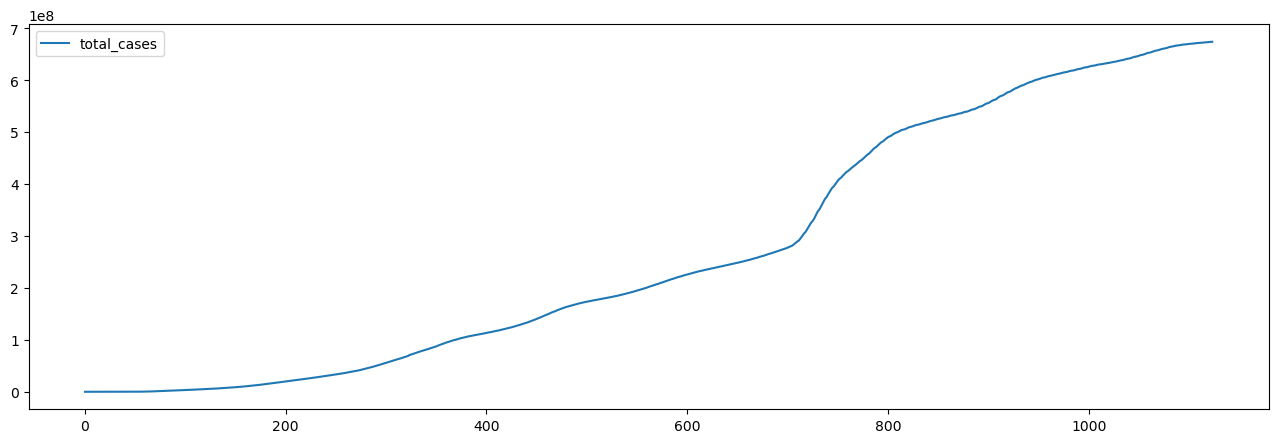

In [5]:
df.plot(figsize=(16,5))

In order to optimise the ARIMA model, we need to make the time series stationary as it's easier to model and make predictions. 

Splitting the data and setting the test data to the last 60 days

In [6]:
msk = (df.index < len(df)-60)
df_train = df[msk].copy()
df_test = df[~msk].copy()

In [7]:
adf_test = adfuller(df_train["total_cases"])
print(f"{adf_test[1]:.3f}")

0.987


We can check stationarity using an Augmented Dickey-Fuller (ADF) test.
We are check if the p-value is greater than, less than or equal to 0.05.
If p-value > 0.05: the ADF failed to reject the null hypothesis and the data is non-stationary.
If p-value <= 0.05: the ADF rejected the null hypothesis and the data is stationary.

Determining the d for I(d). To determine d we need check seasonality, stationarity and differencing using ACF and PACF plots.

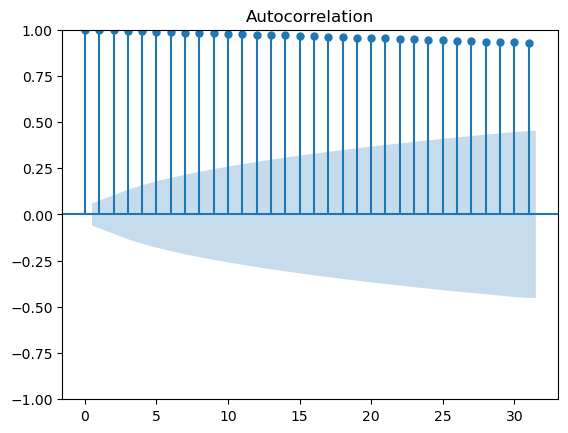

In [8]:
acf_original = plot_acf(df_train["total_cases"])

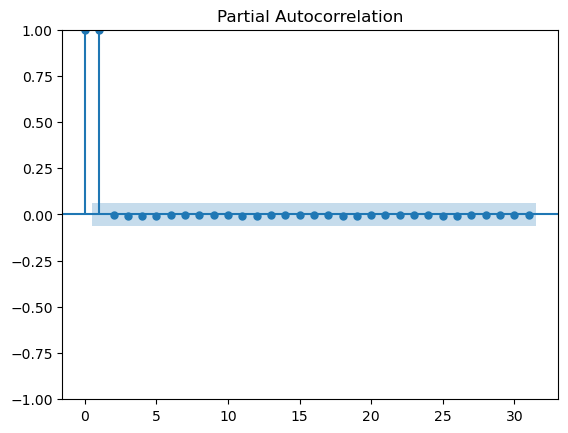

In [9]:
pacf_original = plot_pacf(df_train["total_cases"])

The ACF plot is showing exponential decay, this is indicative of a tread. We can remove this trend by applying differencing to our data.

While the PACF is showing strong positive correlation at lag 1 and also cuts off after lag 1.

<AxesSubplot:>

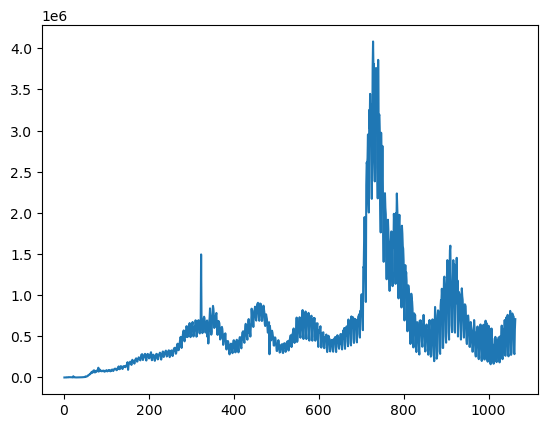

In [10]:
df_train_diff = df_train["total_cases"].diff().dropna()
df_train_diff.plot()

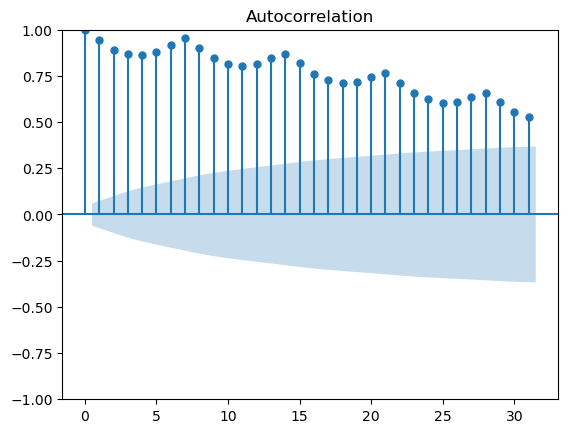

In [11]:
acf_diff = plot_acf(df_train_diff)

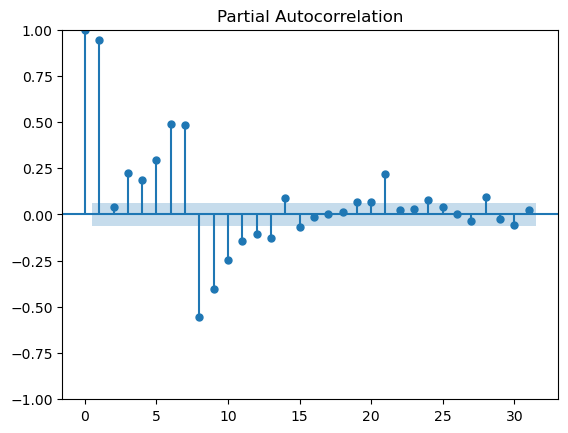

In [12]:
pacf_diff = plot_pacf(df_train_diff)

The ACF plot is still displaying decay.

The ACF and is showing us at differencing order 1 there is still a trend. We can applying differencing at order 2 to resolve this. 

<AxesSubplot:>

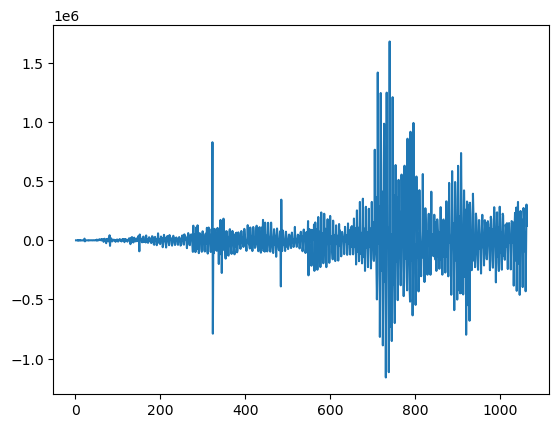

In [13]:
df_train_diff_o2 = df_train_diff.diff()
df_train_diff_o2.plot()

In [14]:
df_train_diff_o2 = df_train_diff_o2.dropna()

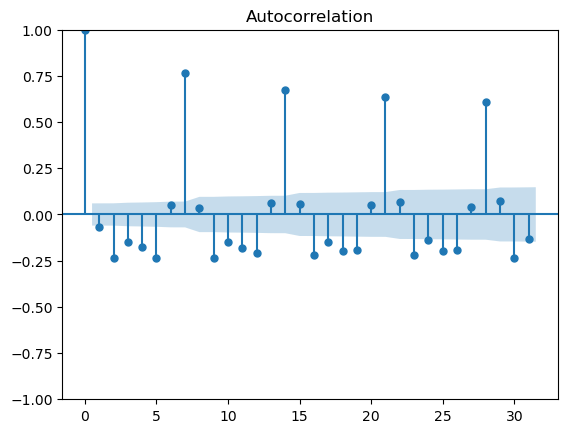

In [15]:
acf_diff_o2 = plot_acf(df_train_diff_o2)

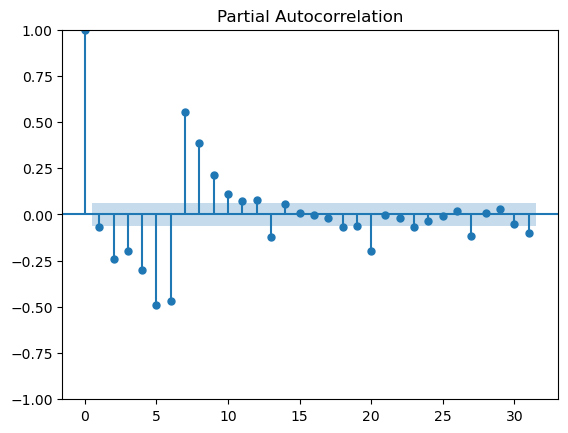

In [16]:
pacf_diff_o2 = plot_pacf(df_train_diff_o2)

At difference order 2 we can see that the data is now stationary and the ACF isn't showing a decaying trend.

Therefore we will use d = 2

In [17]:
model_order = []
AIC = []
for ar in range(6):
    for ma in range(6):
        model = ARIMA(df_train["total_cases"], order=(ar, 2, ma))
        model_fit = model.fit()
        model_order.append(f"ARIMA({ar},2,{ma})")
        AIC.append(model_fit.aic)

In [18]:
arima_order_df = pd.DataFrame(list(zip(model_order, AIC)), columns=["ARIMA(p,d,q)", "AIC"])
arima_order_df.sort_values("AIC").head(5)

,"ARIMA(p,d,q)",AIC
35,"ARIMA(5,2,5)",27983.181746
34,"ARIMA(5,2,4)",27986.013703
33,"ARIMA(5,2,3)",28085.406256
32,"ARIMA(5,2,2)",28097.707107
29,"ARIMA(4,2,5)",28132.686437


In [19]:
model = ARIMA(df_train["total_cases"], order=(5,2,5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                 1064
Model:                 ARIMA(5, 2, 5)   Log Likelihood              -13980.591
Date:                Mon, 20 Feb 2023   AIC                          27983.182
Time:                        11:04:21   BIC                          28037.829
Sample:                             0   HQIC                         28003.891
                               - 1064                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2186      0.053      4.149      0.000       0.115       0.322
ar.L2         -0.9376      0.044    -21.550      0.000      -1.023      -0.852
ar.L3         -0.0767      0.074     -1.035      0.3

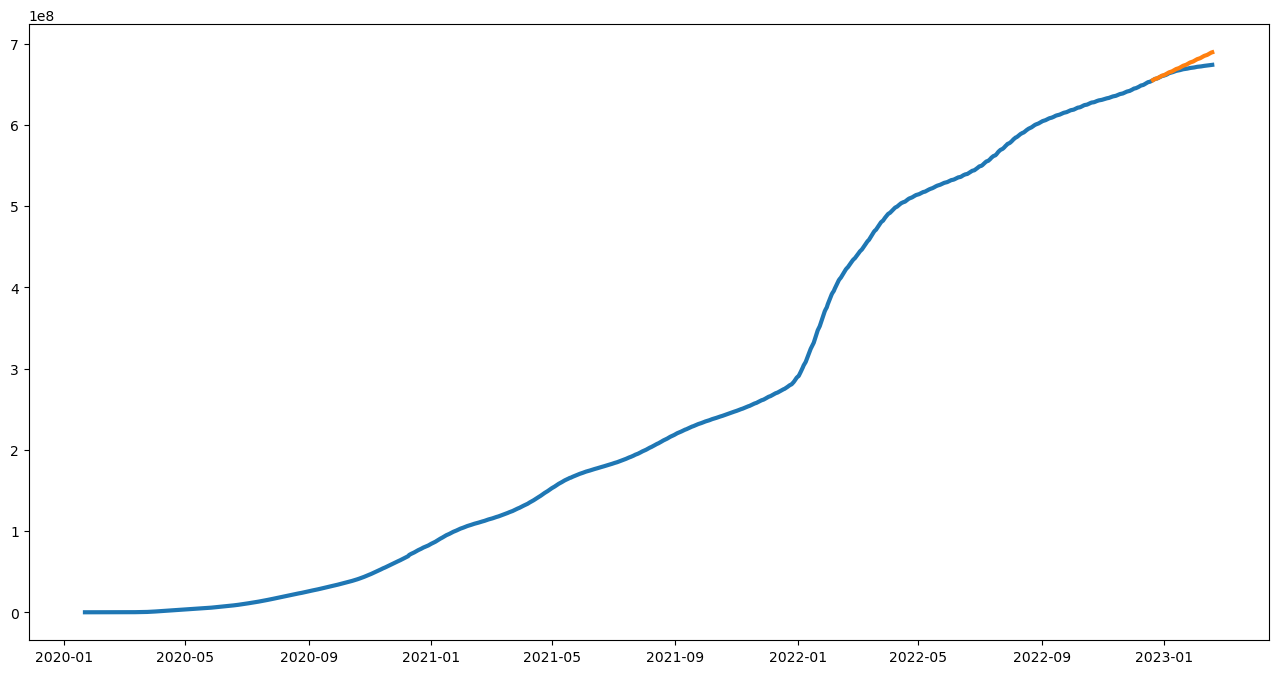

In [22]:
forecast = model_fit.forecast(len(df_test))
df["date"] = pd.to_datetime(df["date"])
df["ARIMA"] = [None]*len(df_train["total_cases"]) + list(forecast)

plt.figure(figsize=(16,8))
plt.plot(df["date"], df["total_cases"], linewidth=3)
plt.plot(df["date"], df["ARIMA"], linewidth=3)
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test["total_cases"], forecast)
mape = mean_absolute_percentage_error(df_test["total_cases"], forecast)
rmse = np.sqrt(mean_absolute_error(df_test["total_cases"], forecast))

print(f"mae: {mae}")
print(f"mape: {mape}")
print(f"rmse: {rmse}")

mae: 5407554.316235467
mape: 0.008057454249902129
rmse: 2325.414869702924
